In [77]:
from sklearn.manifold import TSNE
from numpy import reshape
import numpy as np
import seaborn as sns
import pandas as pd  
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import umap
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import pickle
import einops
from numpy import linalg as LA

In [78]:
# https://stackoverflow.com/questions/53968004/how-to-silence-all-sklearn-warning
import warnings
warnings.filterwarnings('ignore') 

In [79]:
import glob
import regex as re

files = glob.glob('../data/mimic3/new_extended_data_unique_embed_*.pickle')
regex = r"new_extended_data_unique_embed_(.*?).pickle"

test_str = " ".join(files)
matches = re.finditer(regex, test_str, re.MULTILINE)

datasets = [match.groups()[0] for match in matches]
datasets.sort()

print(datasets)

dslist = [
 'BERT_chunked_meanpooler_prepro',
 'BioBERT_chunked_meanpooler_prepro',
 'BioELECTRA_chunked_meanpooler_prepro',
 'CliBERT_2m_chunked_meanpooler_prepro',
 'Doc2Vec_prepro',
 'GPT-2_chunked_meanpooler_prepro',
 'PubMedBERT_chunked_meanpooler_prepro',
 'RoBERTa_chunked_meanpooler_prepro',
 'SentenceTransformer_chunked_prepro',
 's2v']

removelist = [d for d in datasets if d not in dslist]

for r in removelist:
    try:
         datasets.remove(r) # CNEP is an old variant, not used anymore
    except:
         pass

datasets

['BERT', 'BERT_', 'BERT_chunked', 'BERT_chunked_meanpooler', 'BERT_chunked_meanpooler_prepro', 'BERT_chunked_nopooler', 'BERT_chunked_pooler', 'BERT_chunked_pooler_prepro', 'BERT_chunked_prepro', 'BERT_large', 'BERT_meanpooler', 'BERT_meanpooler_prepro', 'BERT_pooler', 'BERT_pooler_prepro', 'BERT_prepro', 'BioBERT', 'BioBERT_chunked', 'BioBERT_chunked_meanpooler_prepro', 'BioELECTRA_chunked_meanpooler_prepro', 'CNEP', 'CliBERT_1m', 'CliBERT_1m_chunked', 'CliBERT_2m', 'CliBERT_2m_chunked', 'CliBERT_2m_chunked_meanpooler_prepro', 'CliBERT_2m_chunked_prepro', 'Doc2Vec_', 'Doc2Vec_chunked_prepro', 'Doc2Vec_prepro', 'GPT-2_chunked_meanpooler_prepro', 'GPT2_chunked_meanpooler', 'PubMedBERT_chunked_meanpooler', 'PubMedBERT_chunked_meanpooler_prepro', 'RoBERTa', 'RoBERTa_chunked', 'RoBERTa_chunked_meanpooler_prepro', 'ST_all-mpnet-base-v2', 'ST_distilbert', 'ST_robertabase', 'ST_stsb-mpnet-base-v2', 'SentenceTransformer_chunked_prepro', 'd2v', 's2v', 's2v_chunked', 's2v_plain', 's2v_prepro']


['BERT_chunked_meanpooler_prepro',
 'BioBERT_chunked_meanpooler_prepro',
 'BioELECTRA_chunked_meanpooler_prepro',
 'CliBERT_2m_chunked_meanpooler_prepro',
 'Doc2Vec_prepro',
 'GPT-2_chunked_meanpooler_prepro',
 'PubMedBERT_chunked_meanpooler_prepro',
 'RoBERTa_chunked_meanpooler_prepro',
 'SentenceTransformer_chunked_prepro',
 's2v']

In [80]:
dataset_map2name = {
 'BERT_chunked_meanpooler_prepro': 'BERT',
 'BioBERT_chunked_meanpooler_prepro': 'BioBERT',
 'BioELECTRA_chunked_meanpooler_prepro': 'BioELECTRA',
 'CliBERT_2m_chunked_meanpooler_prepro': 'Clinical BERT, two models',
 'Doc2Vec_prepro': 'Doc2Vec',
 'GPT-2_chunked_meanpooler_prepro': 'GPT-2',
 'PubMedBERT_chunked_meanpooler_prepro': 'PubMedBERT',
 'RoBERTa_chunked_meanpooler_prepro': 'RoBERTa',
 'SentenceTransformer_chunked_prepro': 'Sentence Transformer, basemodel: all-mpnet-base-v2',
 's2v': 'Sent2Vec'}

In [171]:
from pltlatexify import latexify, format_axes

def plot_scatter_with_colorbar(df_, color_palette, tsne=True):
    sns.set(rc={'figure.figsize':(8, 6)})
    latexify(fig_width=8, fig_height=6)
    
    sns_plot = sns.scatterplot(x="comp1", y="comp2", hue=df_.y.tolist(), 
                    # palette=sns.color_palette(color_palette, as_cmap=True),
                    palette=color_palette, # color_palette.N
                    data=df_)
    plottype = 'T-SNE' if tsne else 'UMAP'
    sns_plot.set(title=f"{plottype} projection of MIMIC-III train data notes embeddings, model {dataset_map2name[dataset]}.")

    # norm = plt.Normalize(df_.y.min(), df_.y.max())
    # sm = plt.cm.ScalarMappable(cmap='rocket', norm=norm) # color_palette, norm=norm)
    # sm.set_array([])

    plt.rcParams['axes.grid'] = False
    #sns_plot.set_ylabel('n passengers')
    # sns_plot.get_legend().remove()
    # sns_plot.figure.colorbar(sm, label='Norm')
    
    handles, labels  =  sns_plot.get_legend_handles_labels()
    sns_plot.legend(handles, ['Embeddings Discharge Notes', 'Embeddings Event Notes']) #, loc='lower right')
    
    sns_plot.set_xlabel("X component")
    sns_plot.set_ylabel("Y component")
    # sns_plot.set_title("Title")
    plt.tight_layout()
    format_axes(sns_plot)
    plt.show();
    fig = sns_plot.get_figure()
    fig.savefig(f"./plots/{plottype}/plot_{dataset}_{plottype}.pdf") #, bbox_inches='tight', pad_inches = 0)
    
    # fig = sns_plot.get_figure()
    # fig.savefig(f"./plots/{plottype}/plot_{dataset}_{plottype}.png", bbox_inches='tight', pad_inches = 0)


In [172]:
# for dataset in datasets[0:3]:
#     print(dataset)
#     df = pickle.load(open(f'../data/mimic3/new_extended_data_unique_embed_{dataset}.pickle', 'rb'))
#     x1 = df['embeds']
#     x2 = df['embeds_events']
#     # y = df['labels']
#     X = np.concatenate([x1, x2])
#     #y = LA.norm(X, axis=-1)
    
#     distortions = []
#     r = range(1,11)
#     for n in tqdm(r):
#         km = KMeans(n_clusters=n,
#                     init='random',
#                     n_init=10,
#                     max_iter=300,
#                     tol=1e-4,
#                     random_state=4711)
#         km.fit(X)
#         distortions.append(km.inertia_)
                        
#     plt.plot(r, distortions, marker='o')
#     plt.xlabel("Number of clusters")
#     plt.ylabel("Distortion")
#     plt.tight_layout()

# plt.show()

# MIMIC embeddings data T-SNE and UMAP

## Plot all datasets and save plots to file

BERT_chunked_meanpooler_prepro


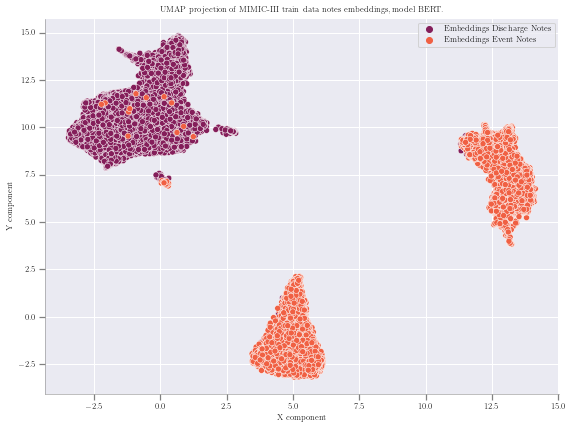

BioBERT_chunked_meanpooler_prepro


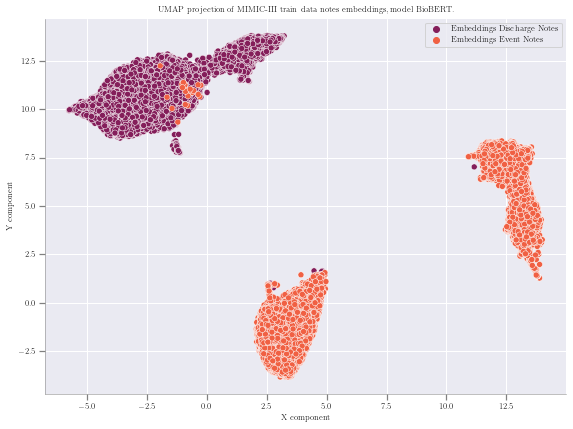

BioELECTRA_chunked_meanpooler_prepro


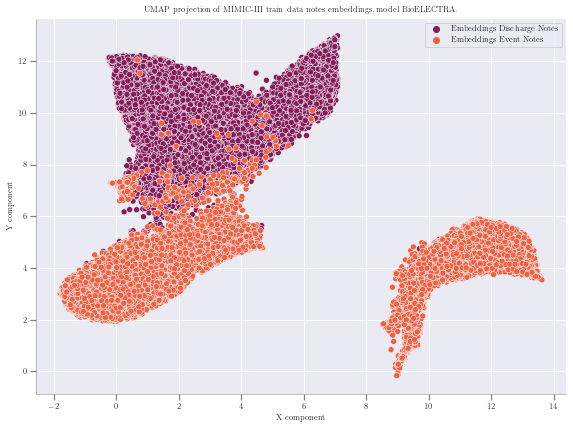

CliBERT_2m_chunked_meanpooler_prepro


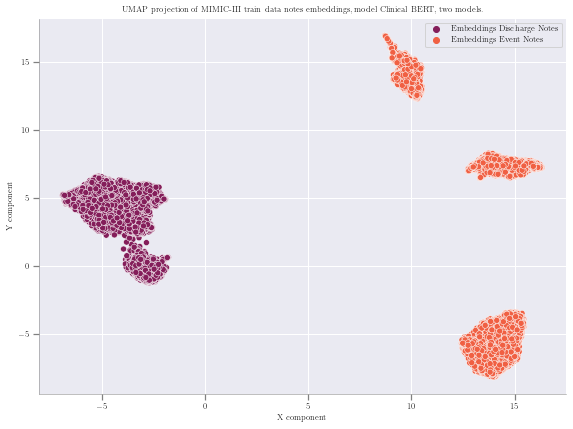

Doc2Vec_prepro


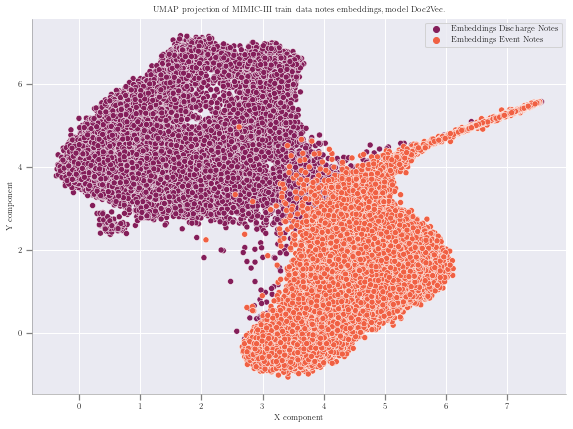

GPT-2_chunked_meanpooler_prepro


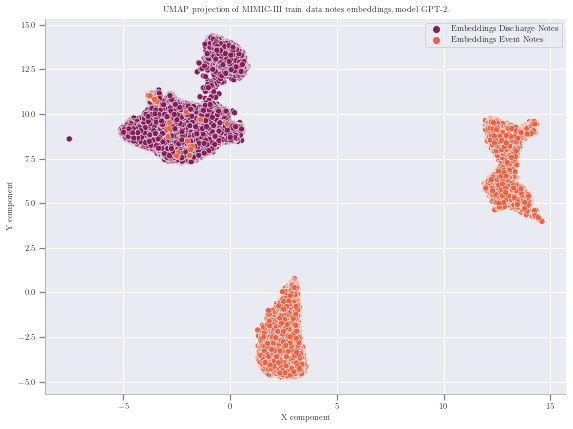

PubMedBERT_chunked_meanpooler_prepro


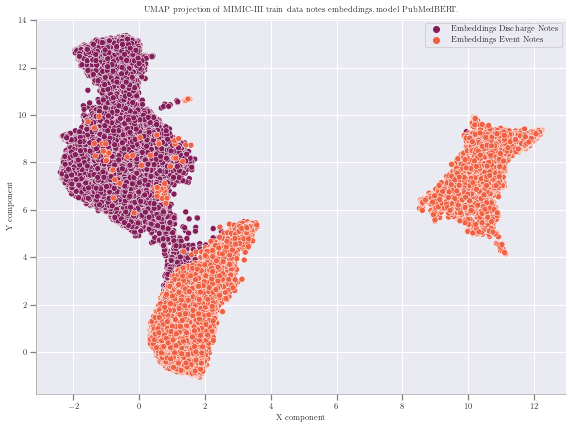

RoBERTa_chunked_meanpooler_prepro


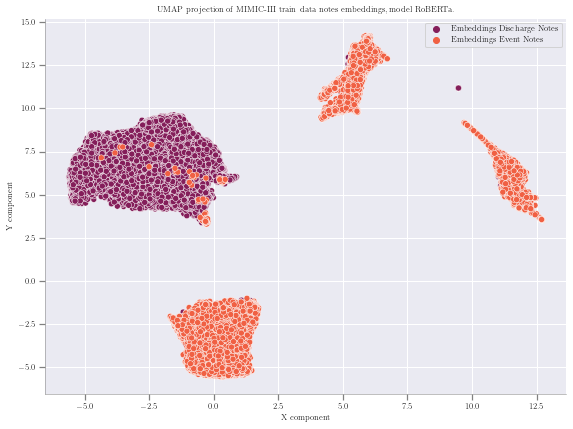

SentenceTransformer_chunked_prepro


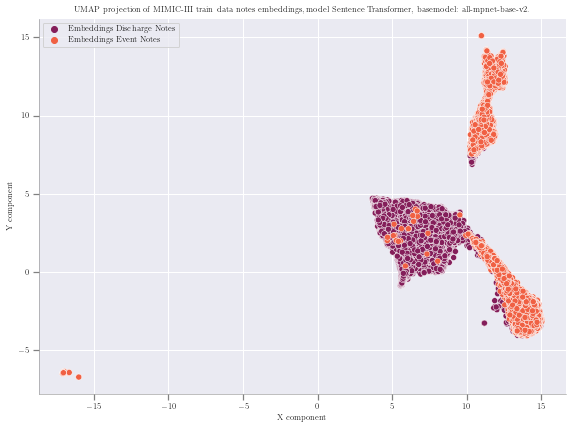

s2v


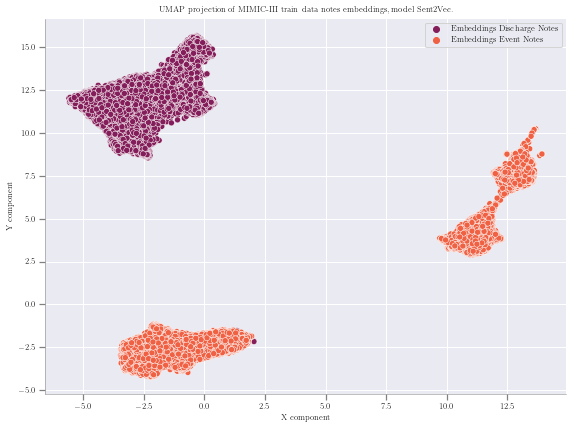

In [175]:
maxn = None
n_clusters = 4

for dataset in datasets:
    print(dataset)
    df = pickle.load(open(f'../data/mimic3/new_extended_data_unique_embed_{dataset}.pickle', 'rb'))
    x1 = df['embeds']
    x2 = df['embeds_events']
    
    y = np.concatenate([np.array([0] * len(x1)), np.array([1] * len(x2))])
    # y = np.concatenate([np.array([0] * (maxn // 2)), np.array([1] * (maxn // 2))])
    y = y.astype(np.float32)
    X = np.concatenate([x1, x2])
    # y = LA.norm(X, axis=-1)
    
    # km = KMeans(n_clusters=n_clusters,
    #                 init='random',
    #                 n_init=10,
    #                 max_iter=300,
    #                 tol=1e-4,
    #                 random_state=4711)
    # y = km.fit_predict(X)

    X = X[:maxn,:]
    y = y[:maxn]
    
    # compute T-SNE projection
    # tsne = TSNE(n_components=2, verbose=0, init='pca', perplexity=100, learning_rate=200)
    # z = tsne.fit_transform(X)
    
    # compute UMAP projection
    reducer = umap.UMAP(n_components=2, n_neighbors=200, min_dist=0.1)
    # scaled_X = StandardScaler().fit_transform(X)
    embedding = reducer.fit_transform(X)
    # embedding.shape, X.shape, y.shape
    
    df_ = pd.DataFrame()
    df_["y"] = y
    # df_["comp1"] = z[:,0]
    # df_["comp2"] = z[:,1]
    # color_palette = 'magma'
    # color_palette = mcolors.ListedColormap(["green", "blue"])
    color_palette=sns.color_palette("rocket", n_colors=len(np.unique(y)))
    # sns.color_palette("rocket", n_colors=2)
   
    # plot_scatter_with_colorbar(df_, color_palette, True)
    
    df_["comp1"] = embedding[:,0]
    df_["comp2"] = embedding[:,1]
    
    plot_scatter_with_colorbar(df_, color_palette, False)